In [83]:
# Built in packages
import math
import sys
from pathlib import Path
import time

import json
import requests

from pyzbar import pyzbar
from PIL import Image

# Matplotlib will need to be installed if it isn't already. This is the only package allowed for this base part of the 
# assignment.
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# import our basic, light-weight png reader library
import imageIO.png


class Queue:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []

    def enqueue(self, item):
        self.items.insert(0,item)

    def dequeue(self):
        return self.items.pop()

    def size(self):
        return len(self.items)

# this function reads an RGB color png file and returns width, height, as well as pixel arrays for r,g,b
def readRGBImageToSeparatePixelArrays(input_filename):

    image_reader = imageIO.png.Reader(filename=input_filename)
    # png reader gives us width and height, as well as RGB data in image_rows (a list of rows of RGB triplets)
    (image_width, image_height, rgb_image_rows, rgb_image_info) = image_reader.read()

    print("read image width={}, height={}".format(image_width, image_height))

    # our pixel arrays are lists of lists, where each inner list stores one row of greyscale pixels
    pixel_array_r = []
    pixel_array_g = []
    pixel_array_b = []

    for row in rgb_image_rows:
        pixel_row_r = []
        pixel_row_g = []
        pixel_row_b = []
        r = 0
        g = 0
        b = 0
        for elem in range(len(row)):
            # RGB triplets are stored consecutively in image_rows
            if elem % 3 == 0:
                r = row[elem]
            elif elem % 3 == 1:
                g = row[elem]
            else:
                b = row[elem]
                pixel_row_r.append(r)
                pixel_row_g.append(g)
                pixel_row_b.append(b)

        pixel_array_r.append(pixel_row_r)
        pixel_array_g.append(pixel_row_g)
        pixel_array_b.append(pixel_row_b)

    return (image_width, image_height, pixel_array_r, pixel_array_g, pixel_array_b)


# a useful shortcut method to create a list of lists based array representation for an image, initialized with a value
def createInitializedGreyscalePixelArray(image_width, image_height, initValue = 0):
    '''creates a greyscale pixel array of size image_width * image_height, with all values initialized to initValue'''
    new_array = [[initValue for x in range(image_width)] for y in range(image_height)]
    return new_array

# You can add your own functions here:
def LOG(message):
    print(f"LOGGING INFO-[{round(time.time()-start_time,2)}]: {message}")

def streachTo0_255(px_array):
    '''streaches the greyscale pixel array to 0-255'''
    min = 255
    max = 0
    for i in range(len(px_array)):
        for j in range(len(px_array[0])):
            if px_array[i][j] < min:
                min = px_array[i][j]
            if px_array[i][j] > max:
                max = px_array[i][j]
    for i in range(len(px_array)):
        for j in range(len(px_array[0])):
            px_array[i][j] = int((px_array[i][j] - min) * 255 / (max - min))
    return px_array


def computeHistogram(pixel_array, image_width, image_height, nr_bins = 8):
    '''computes the histogram of the pixel array'''
    histogram = [0] * nr_bins
    for i in range(len(pixel_array)):
        for j in range(len(pixel_array[0])):
            histogram[int(pixel_array[i][j])] += 1
    return histogram

def computeCumulativeHistogram(pixel_array, image_width, image_height, nr_bins):
    '''computes the cumulative histogram of the pixel array'''

    histogram = computeHistogram(pixel_array, image_width, image_height, nr_bins)

    cumulative_histogram = [0] * nr_bins
    cumulative_histogram[0] = histogram[0]
    for i in range(len(cumulative_histogram)):
        cumulative_histogram[i] = cumulative_histogram[i - 1] + histogram[i]
    return cumulative_histogram


def computeRGBToGreyscale(pixel_array_r, pixel_array_g, pixel_array_b, image_width, image_height):
    '''computes given RGB Arrays to greyscale array'''
    greyscale_pixel_array = createInitializedGreyscalePixelArray(image_width, image_height)

    for i in range(image_height):
        for j in range(image_width):
            greyscale_pixel_array[i][j] = int(round(0.299 * pixel_array_r[i][j] + 0.587 * pixel_array_g[i][j] + 0.114 * pixel_array_b[i][j],0))

    return greyscale_pixel_array


def computeMinAndMaxValues(pixel_array, image_width, image_height):
    '''computes the minimum and maximum values of the pixel array'''
    flat_array = [pixel_array[i][j] for i in range(image_height) for j in range(image_width)]
    return (min(flat_array), max(flat_array))

def scaleTo0And255AndQuantize(pixel_array, image_width, image_height):
    '''scales the greyscale pixel array to 0-255 and quantizes it to 8 bits'''
    min, max = computeMinAndMaxValues(pixel_array, image_width, image_height)
    if min-max == 0:
        return list(map(lambda x: list(map(lambda y: 0, x)), pixel_array))
    return list(map(lambda x: list(map(lambda y: int(round(((y - min) * 255 / (max - min)),0)), x)), pixel_array))


def computeVerticalEdgesSobelAbsolute(pixel_array, image_width, image_height):
    '''computes the vertical edges of the pixel array using the Sobel operator'''
    vertical_edges = createInitializedGreyscalePixelArray(image_width, image_height)
    sobel_x = [
                [-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]
            ]

    for i in range(image_height):
        for j in range(image_width):

            if i == 0 or i == image_height - 1 or j == 0 or j == image_width - 1:
                # if we are at the border of the image, we set the value to 0
                vertical_edges[i][j] = 0.0

            else:
                # otherwise we apply the Sobel operator
                            pixel_value = 0.0
                            for di in range(-1, 2):
                                for dj in range(-1, 2):
                                    pixel_value += pixel_array[i+di][j+dj] * sobel_x[di+1][dj+1]

                            vertical_edges[i][j] = abs(pixel_value) / 8
    return vertical_edges


def computeHorizontalEdgesSobelAbsolute(pixel_array, image_width, image_height):
    sobel_y = [[-1, -2, -1], 
               [0, 0, 0], 
               [1, 2, 1]]

    output_image = createInitializedGreyscalePixelArray(image_width, image_height)
    for i in range(1, image_height-1):
        for j in range(1, image_width-1):
            pixel_value = 0.0
            for di in range(-1, 2): 
                for dj in range(-1, 2):
                    pixel_value += pixel_array[i+di][j+dj] * sobel_y[di+1][dj+1]
            output_image[i][j] = abs(pixel_value)/8
    return output_image

def computeBoxAveraging3x3(pixel_array, image_width, image_height):
    output_image = createInitializedGreyscalePixelArray(image_width, image_height)


    for i in range(0, image_height):
        for j in range(0, image_width):
            if i == 0 or i == image_height - 1 or j == 0 or j == image_width - 1:
                # if we are at the border of the image, we set the value to 0
                output_image[i][j] = 0.0
            else:
                output_image[i][j] = abs(pixel_array[i + 1][j - 1] + pixel_array[i + 1][j] + pixel_array[i + 1][j + 1] 
                                        + pixel_array[i][j - 1] + pixel_array[i][j] + pixel_array[i][j + 1] 
                                        + pixel_array[i - 1][j - 1] + pixel_array[i - 1][j] + pixel_array[i - 1][j + 1]) / 9
                                     
    return output_image


def computeGaussianAveraging3x3RepeatBorder(pixel_array, image_width, image_height):
    output_image = createInitializedGreyscalePixelArray(image_width, image_height)
    gaussian_filter = [
                        [1, 2, 1],
                        [2, 4, 2],
                        [1, 2, 1]
                    ]
    for i in range(image_height):
        for j in range(image_width):
            pixel_value = 0.0
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    new_x = max(0, min(di + i, image_height - 1))
                    new_y = max(0, min(dj + j, image_width - 1)) 
                    pixel_value += pixel_array[new_x][new_y] * gaussian_filter[di+1][dj+1]
            output_image[i][j] = round((pixel_value *  1/16),2)
    return output_image

def computeStandardDeviationImage3x3(pixel_array, image_width, image_height):
    output_image = createInitializedGreyscalePixelArray(image_width, image_height)

    for i in range(1, image_height - 1):
        for j in range(1, image_width - 1):
            mean = 0
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    mean += pixel_array[i + di][j + dj]
            mean /= 9.0
            variance = 0

            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    variance += math.pow(pixel_array[i + di][j + dj] - mean, 2)

            variance /= 9.0

            standard = math.sqrt(variance)
            output_image[i][j] = standard
    
    return output_image

def computeThresholdGE(pixel_array, threshold_value, image_width, image_height):
    '''computes the thresholded image'''
    return list(map(lambda i: list(map(lambda j: 255 if j >= threshold_value else 0, i)), pixel_array))

def computeDilation8Nbh5x5FlatSE(pixel_array, image_width, image_height):
    output = createInitializedGreyscalePixelArray(image_width, image_height)
    for i in range(image_height):
        for j in range(image_width):
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    if 0 <= i+di < image_height and 0 <= j+dj < image_width:
                        if pixel_array[i + di][j + dj] > 0:
                            output[i][j] = 1
                            break
                if output[i][j] == 1:
                    break
    return output

def computeErosion8Nbh5x5FlatSE(pixel_array, image_width, image_height):
    output = createInitializedGreyscalePixelArray(image_width, image_height)
    for i in range(image_height):
        for j in range(image_width):
            misses = False
            for di in range(-1, 2):
                for dj in range(-1, 2):
                    if 0 <= i+di < image_height and 0 <= j+dj < image_width:
                        if pixel_array[i+di][j+dj] == 0:
                            # pixel misses
                            misses=True
                            break
                    else:
                        misses=True
                        break
                if misses:
                    break
            if not misses:
                output[i][j] = 1
    return output


def computeConnectedComponentLabeling(pixel_array, image_width, image_height):
    map = [(0, -1), (-1, 0), (1, 0), (0, 1)]

    # initialise label counter and dictionary to keep track of label sizes
    c = 1
    label_dict = {}
    
    # create an output image array and visited flag array with same size as input image
    labeled_image = createInitializedGreyscalePixelArray(image_width, image_height)
    visited = createInitializedGreyscalePixelArray(image_width, image_height)
    
    queue = Queue()

    for i in range(image_height):
        for j in range(image_width):

            if pixel_array[i][j] > 0 and visited[i][j] == 0:
                queue.enqueue((i, j))
                while not queue.isEmpty():
                    x, y = queue.dequeue()

                    if visited[x][y] == 0:
                        visited[x][y],labeled_image[x][y] = 1,c

                        dic = label_dict.get(c,None)
                        if dic == None:
                            label_dict[c] = [1, x, x, y, y]
                            
                        else:
                            dic = label_dict[c]
                            x_min = min(dic[1], x)
                            x_max = max(dic[2], x)
                            y_min = min(dic[3], y)
                            y_max = max(dic[4], y)
                            count = dic[0] + 1
                            label_dict[c] = [count, x_min, x_max, y_min, y_max]

                        for dx, dy in map:

                            if 0 <= x+dx < image_height and 0 <= y+dy < image_width:
                                if pixel_array[x+dx][y+dy] > 0 and visited[x+dx][y+dy] == 0:
                                    queue.enqueue((x+dx, y+dy))
                c += 1

    return labeled_image, label_dict

def calculate_aspect_ratio(x_min, x_max, y_min, y_max):
    # Calculate the width and height of the square
    width = abs(x_max - x_min)
    height = abs(y_max - y_min)
    
    # Calculate the aspect ratio
    aspect_ratio = width / height
    return aspect_ratio

def filter_aspect_ratio(label_dict):
    log_c = 0
    ratios = []
    keys_to_remove = []
    for i in label_dict.keys():
        # remove all components that have the wrong aspect ratio
        ratio = round(calculate_aspect_ratio(label_dict[i][1], label_dict[i][2], label_dict[i][3], label_dict[i][4]),3)
        
        if not (1.5 <= ratio and ratio <= 1.9):
            log_c += 1
            keys_to_remove.append(i)
            LOG(f"component {i} has wrong aspect ratio {ratio}")
        else:
            ratios.append(ratio)
       
    for i in keys_to_remove:
        del label_dict[i]
    LOG(f"removed {log_c} components with wrong aspect ratio")
    LOG(f"aspect ratios: {ratios}")

    return label_dict

def computeBoundBox(labeled_img,labeled_dict,image_width,image_height,largest_component_key):

    output_array = createInitializedGreyscalePixelArray(image_width, image_height)

    x_values = set()
    y_values = set()

    for i in range(image_height):
        if largest_component_key in labeled_img[i]:
            output_array[i] = labeled_img[i]
            for j in range(image_width):
                if labeled_img[i][j] == largest_component_key:
                    y_values.add(i)
                    x_values.add(j)

    return min(x_values), min(y_values), max(x_values) - min(x_values), max(y_values) - min(y_values)

def crop_pixle_array(x_max,x_min,y_max,y_min,pixel_array):
    cropped_array = createInitializedGreyscalePixelArray(x_max-x_min, y_max-y_min)
    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            cropped_array[i-y_min][j-x_min] = pixel_array[i][j]
    return cropped_array

def separateArraysToRGB(px_array_r, px_array_g, px_array_b, image_width, image_height):
    new_array = [[[0 for c in range(3)] for x in range(image_width)] for y in range(image_height)]

    for y in range(image_height):
        for x in range(image_width):
            new_array[y][x][0] = px_array_r[y][x]
            new_array[y][x][1] = px_array_g[y][x]
            new_array[y][x][2] = px_array_b[y][x]

    return new_array

def calc_sobel(greyscaled, image_width, image_height):
    vertical_edges = computeVerticalEdgesSobelAbsolute(greyscaled, image_width, image_height)
    horizontal_edges = computeHorizontalEdgesSobelAbsolute(greyscaled, image_width, image_height)
    # combine the two edges by calculating absolute diffrence
    px_array = [[abs(vertical_edges[i][j] - horizontal_edges[i][j]) for j in range(image_width)] for i in range(image_height)]
    return px_array


def call_api(code):
    # url = f"https://product-lookup-by-upc-or-ean.p.rapidapi.com/code/{code}"

    # headers = {
    #     # TODO: add getter for api key 
    #     "X-RapidAPI-Key": "",
    #     "X-RapidAPI-Host": "product-lookup-by-upc-or-ean.p.rapidapi.com"
    # }

    # response = requests.get(url, headers=headers)
    # json_data = json.loads(response.text)
    # print(response.json())
    # # get attribute from repsonce at product then name

    # return json_data
    code = {'code': '9300657232603', 'codeType': 'EAN', 'product': {'name': 'Watties Butter Chicken Hearty Soup', 'description': 'No description found.', 'region': 'Outside of North America', 'imageUrl': 'https://go-upc.s3.amazonaws.com/images/70199108.jpeg', 'brand': '', 'specs': [], 'category': 'Soups & Broths', 'upc': None, 'ean': 9300657232603}, 'inferred': False}
    return code.get("product").get("name")

def decode_barcode(px_array):
    # decodes all barcodes from an image
    image = Image.new('L', (len(px_array[0]), len(px_array)))
    for y in range(len(px_array)):
        for x in range(len(px_array[y])):
            image.putpixel((x, y), px_array[y][x])

    return str(pyzbar.decode(image)[0][0])[2:-1]

read image width=756, height=357
LOGGING INFO-[0.2]: image width: 756, image height: 357
LOGGING INFO-[0.37]: image grayscaled
LOGGING INFO-[2.06]: soble filter applyed
LOGGING INFO-[3.96]: Gaussian filter applyed step 1 of 4
LOGGING INFO-[5.94]: Gaussian filter applyed step 2 of 4
LOGGING INFO-[7.86]: Gaussian filter applyed step 3 of 4
LOGGING INFO-[9.76]: Gaussian filter applyed step 4 of 4
LOGGING INFO-[9.87]: contrast strech applyed
LOGGING INFO-[9.96]: threshold applyed
LOGGING INFO-[10.9]: erosion step 1 of 3 applyed
LOGGING INFO-[11.14]: erosion step 2 of 3 applyed
LOGGING INFO-[11.38]: erosion step 3 of 3 applyed
LOGGING INFO-[11.6]: dilation step 1 of 5 applyed
LOGGING INFO-[12.57]: dilation step 2 of 5 applyed
LOGGING INFO-[13.53]: dilation step 3 of 5 applyed
LOGGING INFO-[14.48]: dilation step 4 of 5 applyed
LOGGING INFO-[15.43]: dilation step 5 of 5 applyed
LOGGING INFO-[16.52]: conected component analysis applyed 9 components found
LOGGING INFO-[16.52]: largest component

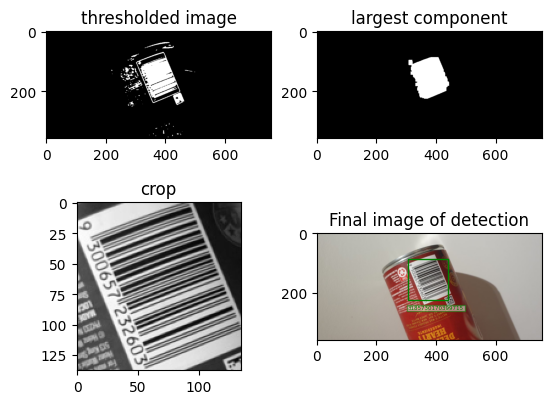

In [64]:

# This is our code skeleton that performs the barcode detection.
# Feel free to try it on your own images of barcodes, but keep in mind that with our algorithm developed in this assignment,
# we won't detect arbitrary or difficult to detect barcodes!
def main():
    # find current time for performance evaluation/logging
    global start_time 
    start_time = time.time()

    SHOW_DEBUG_FIGURES = True

    # this is the default input image filename
    filename = "Barcode1"
    input_filename = "images/"+filename+".png"

    output_path = Path("output_images")
    if not output_path.exists():
        # create output directory
        output_path.mkdir(parents=True, exist_ok=True)

    output_filename = output_path / Path(filename+"_output.png")

    # we read in the png file, and receive three pixel arrays for red, green and blue components, respectively
    # each pixel array contains 8 bit integer values between 0 and 255 encoding the color values
    (image_width, image_height, px_array_r, px_array_g, px_array_b) = readRGBImageToSeparatePixelArrays(input_filename)

    # setup the plots for intermediate results in a figure



    # STUDENT IMPLEMENTATION here

    
    #! STEP 1 Convert to grayscale and normolise
    LOG(f"image width: {image_width}, image height: {image_height}")
    greyscaled = computeRGBToGreyscale(px_array_r, px_array_g, px_array_b, image_width, image_height)
    LOG(f"image grayscaled")
    # quontisise and strech
    # TODO: test if this helps
    # greyscaled = scaleTo0And255AndQuantize(greyscaled, image_width, image_height)   


    #! STEP 2A apply sobel filter
    vertical_edges = computeVerticalEdgesSobelAbsolute(greyscaled, image_width, image_height)
    horizontal_edges = computeHorizontalEdgesSobelAbsolute(greyscaled, image_width, image_height)
    # combine the two edges by calculating absolute diffrence
    px_array = [[abs(vertical_edges[i][j] - horizontal_edges[i][j]) for j in range(image_width)] for i in range(image_height)]
    LOG(f"soble filter applyed")

    #! STEP 2B apply Standard deviation method
    # TODO: currently using standard deviation, will deside later, if need change abs_dif_edges to std
    # blurs the image
    # px_array = computeStandardDeviationImage3x3(px_array, image_width, image_height)
    # LOG("standard deviation applyed")


    #! STEP 3 apply Gaussian filter
    #!! this takes ages!! 
    rounds = 4
    for i in range(rounds):
        px_array = computeGaussianAveraging3x3RepeatBorder(px_array, image_width, image_height)
        LOG(f"Gaussian filter applyed step {i+1} of {rounds}")

    contrast_strech = streachTo0_255(px_array)
    LOG("contrast strech applyed")


    #! STEP 4 apply thresholding
    threshold = computeThresholdGE(px_array, 100, image_width, image_height)
    LOG("threshold applyed")

    #! STEP 5b apply erosion
    dia = computeDilation8Nbh5x5FlatSE(threshold, image_width, image_height)
    for _ in range(3):
        LOG(f"erosion step {_+1} of 3 applyed")
        dia = computeErosion8Nbh5x5FlatSE(dia, image_width, image_height)

    #! STEP 5a apply dilation
    for _ in range(5):
        LOG(f"dilation step {_+1} of 5 applyed")
        dia = computeDilation8Nbh5x5FlatSE(dia, image_width, image_height)    

    #! STEP 6 conected component analysis
    px_array, label_dict = computeConnectedComponentLabeling(dia, image_width, image_height)
    LOG(f"conected component analysis applyed {len(label_dict)} components found")

    #! STEP 7 find largest component with right aspect ratio
    # label_dict = filter_aspect_ratio(label_dict)
    
    #! pick largest component from dict
    largest = 0
    for key in label_dict.keys():
        # LOG(f"component {key} has {label_dict[key][0]} pixels")
        if label_dict[key][0] > largest:
            largest = label_dict[key][0]
            largest_key = key

    LOG(f"largest component {largest_key} has {largest} pixels")

    #! find bounding box
    start_x,start_y,height,width = computeBoundBox(px_array, label_dict, image_width, image_height,largest_key)
    bbox_min_x, bbox_max_x, bbox_min_y, bbox_max_y = start_x, start_x + height, start_y, start_y + width
    LOG(f"x_min = {bbox_min_x}, x_max = {bbox_max_x}, y_min = {bbox_min_y}, y_max = {bbox_max_y}")
    
    # ! add colour back into array
    coloured_array = separateArraysToRGB(px_array_r, px_array_g, px_array_b, image_width, image_height)

    # ! crop the original image
    xpad = 0
    ypad = 0
    cropped_image = crop_pixle_array(bbox_max_x+xpad, bbox_min_x-xpad, bbox_max_y+ypad, bbox_min_y-ypad, greyscaled)
    LOG("cropped image with padding {pad} applyed}")

    # ! take the cropped image and pass it into a barcode scanner
    print(call_api(decode_barcode(cropped_px_array)))
    pyplot.imshow(cropped_px_array, cmap="gray")


    fig1, axs1 = pyplot.subplots(2, 2)
    axs1[0, 0].set_title('thresholded image')
    axs1[0, 0].imshow(threshold, cmap='gray')

    largest_component = createInitializedGreyscalePixelArray(image_width, image_height)
    for i in range(image_height):
        for j in range(image_width):
            if px_array[i][j] != largest_key:
                largest_component[i][j] = 254
            else:
                largest_component[i][j] = 255

    # Show the largest component
    axs1[0, 1].set_title('largest component')
    axs1[0, 1].imshow(largest_component, cmap='gray')

    # Show the edges
    axs1[1, 0].set_title('crop')
    axs1[1, 0].imshow(cropped_image, cmap='gray')



    #! The following code is used to plot the bounding box and generate an output for marking

    # convert the greyscale pixel array to a 3-channel RGB array
    axs1[1, 1].set_title('Final image of detection')
    axs1[1, 1].imshow(coloured_array)

    # Draw a bounding box as a rectangle into the input image
    rect = Rectangle((bbox_min_x, bbox_min_y), bbox_max_x - bbox_min_x, bbox_max_y - bbox_min_y, linewidth=1,
                     edgecolor='g', facecolor='none')
    
    pyplot.text(bbox_min_x, bbox_max_y+30, "3185730170399715", fontsize=4, color="green", bbox=dict(facecolor='white', alpha=0.5, edgecolor='green', pad=0.5))    
    axs1[1, 1].add_patch(rect)

    # write the output image into output_filename, using the matplotlib savefig method
    extent = axs1[1, 1].get_window_extent().transformed(fig1.dpi_scale_trans.inverted())
    pyplot.savefig(output_filename, bbox_inches=extent, dpi=600)

    if SHOW_DEBUG_FIGURES:
        # plot the current figure
        pyplot.show()

# TODO: this is just for testing returns the cropped image and OG to try scan barcode of! 
    return cropped_image
cropped_px_array = main()

Perfect! we have everything loaded into jup notebook now for faster testing, next we must attempt to read the barcode! 

Watties Butter Chicken Hearty Soup


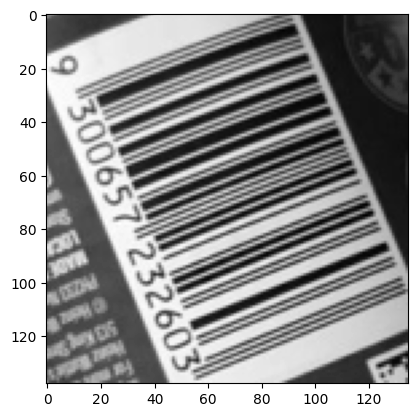

In [84]:



# wanted result = 9300657232603

# img = computeThresholdGE(ret,150,0,0)

def decode_barcode(px_array):
    # decodes all barcodes from an image
    image = Image.new('L', (len(px_array[0]), len(px_array)))
    for y in range(len(px_array)):
        for x in range(len(px_array[y])):
            image.putpixel((x, y), px_array[y][x])

    return str(pyzbar.decode(image)[0][0])[2:-1]

print(call_api(decode_barcode(cropped_px_array)))
pyplot.imshow(cropped_px_array, cmap="gray")
